In [111]:
import glob
import numpy as np

import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker

# matplotlib.style.use('seaborn-v0_8')

In [112]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def extrapolate(x, y, points=12000):
    # calculate polynomial
    z = np.polyfit(x, y, 5)
    f = np.poly1d(z)

    other_x = np.linspace(1, points, int(points/1))
    # other_y = f(other_x)
    other_y = np.interp(other_x, x, y)

    return other_x, other_y

def prepare_data(files, weight, points=12000):
    d = []
    for f in files:
        tmp = None
        if f.endswith('.csv'):
            tmp = csv_to_list(f)
            tmp[1] = smooth(tmp[1], weight)
            _x, _y = extrapolate(tmp[0], tmp[1], points)
            tmp = _y
        else:
            tmp = npy_to_list(f)
            tmp = smooth(tmp, weight)
        d.append(tmp)
    x = []
    if f.endswith('.csv'):
        x = _x
    else:
        x = np.linspace(0, 150.0*len(d[0]), len(d[0]))
    print(np.array(d).shape)
    y = np.average(d, axis=0)
    y_std = np.std(d, axis=0) 
    return x, y, y_std

def npy_to_list(filename):
    data = np.load(filename)
    data = np.sum(data, axis=3)
    data = data.reshape(-1)
    return data

def csv_to_list(filename):
    with open(filename, 'r') as f:
        csv_data = list(csv.reader(f, delimiter=","))
    l = np.array(csv_data[:], dtype=np.float64).T
    print(l.shape)
    return l

def numpy_ewma_vectorized(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

In [150]:


def cumulative_reward_per_step(data, scale_factor=True):
    reward_details = np.array(data[:, 2])
    total_rewards = [0]
    print('?', scale_factor)
    for episode_rewards in reward_details:
        for rw in episode_rewards:
            r = rw[0] + rw[1]
            if rw[2] < 0:
                r += -300
            if rw[3] > 10 or (not scale_factor and rw[0] > 0.68):
                r += 500
            # - step
            # if scale_factor:
            r -= 1.0
            total_rewards.append(total_rewards[-1]+r)

    return np.array(total_rewards)


def sum_reward_per_eps(rewards, cumulative=False):
    reward_per_eps = [0]
    total = 0
    for rw in rewards:
        if cumulative:
            if rw[-1] > -450 and rw[-1] < 450:
                total += np.sum(rw)
            if rw[-1] > 450:
                total += np.sum(rw[:-1]) + 10
            if rw[-1] < -450:
                total -= np.sum(rw[:-1]) - 10
            reward_per_eps.append(total)
        else:
            reward_per_eps.append(np.sum(rw))
    return reward_per_eps


def flatten(rewards):
    rewards_flattened = np.array([])
    for rw in rewards:
        rewards_flattened = np.append(rewards_flattened, rw)
    return rewards_flattened


def load_common_data(folder_names):
    combined_data = [load_data(folder) for folder in folder_names]
    return np.concatenate(combined_data)


def load_data(folder_name, detailed=False):
    print(folder_name)
    if detailed:
        filename = glob.glob(folder_name+'/detailed_*')
    else:
        filename = glob.glob(folder_name+'/state_*')
    if len(filename) > 0:
        return np.load(filename[0], allow_pickle=True)
    raise ValueError("File not found: %s" % (filename))


def single_plot_detailed(ax, folders, label='', color='C0', cumulative=False):
    reward = []
    time_steps = []
    min_len = 10e8
    min_index = 0
    for i, f in enumerate(folders):
        data = load_data(f, detailed=True)

        r = data[:, 3].flatten()
        r = smooth(r, 0.99)
        time_steps.append(data[:, 1])
        
        reward.append(r)
        if len(r) < min_len:
            min_len = len(r)
            min_index = i

    for i in range(len(reward)):
        reward[i] = reward[i][:min_len]

    print(len(reward[0]), len(reward[1]))

    np_data = np.stack((reward[0], reward[1]))
    y = np.average(np_data, axis=0)
    y_std = np.std(np_data, axis=0)

    x = time_steps[min_index]
    ax.plot(x, y, color=color, label=label)
    ax.fill_between(x, y-y_std, y+y_std, antialiased=True, linewidth=0.5, alpha=0.2, facecolor=color)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))


def print_successful_episodes(data):
    rewards = np.array(data[:, 1])
    reward_details = np.array(data[:, 2])
    successes = 0
    for episode_rewards in reward_details:
        if episode_rewards[-1][4] > 0:
            successes += 1
        elif episode_rewards[-1][0] > 0.39:
            successes += 1
    print("num of successes", successes, 'out of', len(reward_details), '%', round(successes/len(reward_details), 2))


# Format the x-ticks to display as 10K and above
def format_func(value, tick_number):
    if value >= 10000:
        value = value / 1000.0
        return f"{value:.0f}K"
    else:
        return f"{int(value):,}"


def single_plot(ax, folder, label='', color='C0', cumulative=False, episode_length=False):
    data = load_data(folder, detailed=True)

    if episode_length:
        y = np.array(data[:, 2])
        x = np.array(data[:, 1])
        ax.plot(x, y, color=color, alpha=0.2, linewidth=0.5)
        y = smooth(y, 0.9)
    else:
        y = np.array(data[:, 3])
        x = np.array(data[:, 1])
        ax.plot(x, y, color=color, alpha=0.2, linewidth=0.5)
        y = smooth(y, 0.99)

    ax.plot(x, y, color=color, label=label)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))


def single_plot2(data, label='', color='C0', cumulative=False):
    rewards = np.array(data[:, 1])

    if cumulative:
        y = cumulative_reward_per_step(data, False)
        x = np.linspace(0, len(y), len(y))
        print(len(y))
    else:
        y = np.array(sum_reward_per_eps(rewards))
        x = np.linspace(0, len(y), len(y))
        plt.plot(x, y, color=color, alpha=0.2)
        # y = numpy_ewma_vectorized(np.array(sum_reward_per_eps(rewards)), 50)
        y = smooth(np.array(sum_reward_per_eps(rewards)), 0.5)
    plt.plot(x, y, color=color, label=label)


def multi_plot(folder_names, labels=None, cumulative=False, episode_length=False):
    if not labels:
        labels = folder_names
    _colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(5)
    for i, folder in enumerate(folder_names):
        if isinstance(folder, list):
            single_plot_detailed(ax, folder, label=labels[i], color=_colors[i], cumulative=cumulative)
        else:
            single_plot(ax, folder, label=labels[i], color=_colors[i], cumulative=cumulative, episode_length=episode_length)


/root/o2ac-ur/results/SAC_norm_vel_y


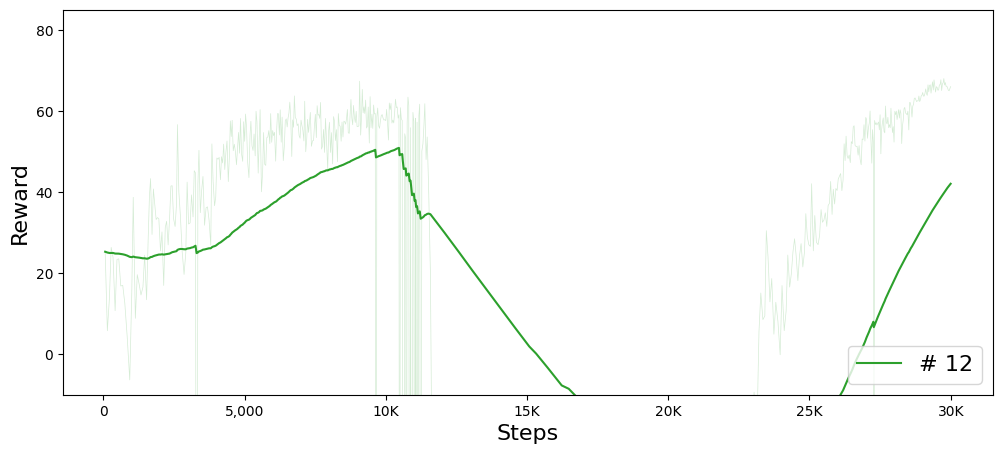

In [149]:
cumulative = False
episode_length = False
fig, ax = plt.subplots()

# single_plot(ax, "/root/o2ac-ur/results/interesting/01_SAC_slicing", label="01", color='C0', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/02_SAC_slicing", label="02", color='C1', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/03_SAC_slicing", label="03", color='C2', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/04_SAC_slicing", label="04", color='C3', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/05_SAC_slicing", label="05", color='C4', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/06_SAC_slicing", label="06", color='C5', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/07_SAC_slicing", label="# 07", color='C6', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/08_SAC_slicing", label="# 08", color='C4', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/09_SAC_slicing", label="# 09", color='C5', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/10_SAC_slicing", label="# 10", color='C0', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/11_SAC_slicing", label="# 11", color='C1', cumulative=cumulative, episode_length=episode_length)
single_plot(ax, "/root/o2ac-ur/results/SAC_norm_vel_y", label="# 12", color='C2', cumulative=cumulative, episode_length=episode_length)
# single_plot(ax, "/root/o2ac-ur/results/interesting/13_SAC_slicing", label="# 13", color='C3', cumulative=cumulative, episode_length=episode_length)
# single_plot("/root/o2ac-ur/results/20230220T223331.856287_SAC_slicing", label="10", color='C1', cumulative=cumulative, episode_length=episode_length)
if cumulative:
    plt.ylabel('Cumulative Reward', size=16)
elif episode_length:
    plt.ylabel('Episode length', size=16)
else:
    plt.ylabel('Reward', size=16)
plt.xlabel('Steps', size=16)
plt.ylim(-10,85)
# plt.xlim(0,51000)
# plt.ticklabel_format(style=('sci'), scilimits=(-5,3), useMathText=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='lower right', fontsize=16)

/root/o2ac-ur/results/SAC_norm_vel_y
/root/o2ac-ur/results/SAC_norm_vel_x
533 533
/root/o2ac-ur/results/SAC_last_obs_y
/root/o2ac-ur/results/SAC_last_obs_x
691 691
/root/o2ac-ur/results/SAC_tcn3_y
/root/o2ac-ur/results/SAC_tcn3_x
944 944
/root/o2ac-ur/results/SAC_tcn6_y
/root/o2ac-ur/results/SAC_tcn6_x
894 894
/root/o2ac-ur/results/SAC_def_y
/root/o2ac-ur/results/SAC_def_x
703 703


(0.0, 65.0)

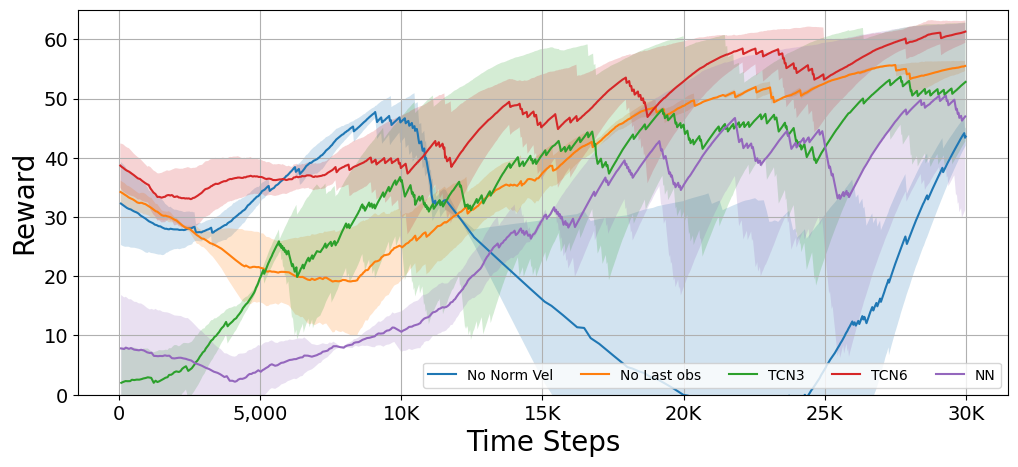

In [153]:
cumulative = False
episode_length = False
folders =[
["/root/o2ac-ur/results/SAC_norm_vel_y",
"/root/o2ac-ur/results/SAC_norm_vel_x"],
["/root/o2ac-ur/results/SAC_last_obs_y",
"/root/o2ac-ur/results/SAC_last_obs_x"],
["/root/o2ac-ur/results/SAC_tcn3_y",
"/root/o2ac-ur/results/SAC_tcn3_x"],
["/root/o2ac-ur/results/SAC_tcn6_y",
"/root/o2ac-ur/results/SAC_tcn6_x"],
["/root/o2ac-ur/results/SAC_def_y",
"/root/o2ac-ur/results/SAC_def_x"],
]
labels = ["No Norm Vel", "No Last obs", "TCN3", "TCN6", "NN"]
multi_plot(folders, labels, cumulative=True)
plt.xlabel('Time Steps', size=20)
plt.ylabel('Reward', size=20)
# plt.ticklabel_format(style=('sci'), scilimits=(-5,3), useMathText=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
# plt.legend(loc='lower left', fontsize=12)
plt.legend(loc="lower right", ncol=5)
plt.ylim(0, 65)

In [116]:
d = np.load("/root/o2ac-ur/results/interesting/10_SAC_slicing/detailed_log.npy")
d[1]

FileNotFoundError: [Errno 2] No such file or directory: '/root/o2ac-ur/results/interesting/10_SAC_slicing/detailed_log.npy'